Detect Corner 

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
import os

## Corner Detection

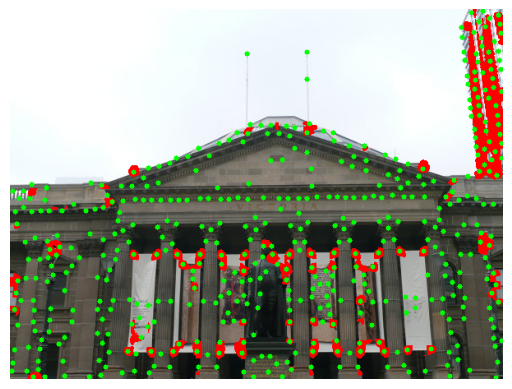

In [43]:
# Path to the image file
image_path = "../Data/Train/Set1/1.jpg"  # Ensure the correct image file name and type

# Read the image from the specified path
img = cv2.imread(image_path)
# Check if the image was successfully read
if img is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply the Harris corner detection
# img: input image
# blocksize: size of the neighborhood considered for corner detection
# ksize: aperture parameter of the Sobel derivative used
# k: Harris detector free parameter
harris_corners = cv2.cornerHarris(gray, 10, 15, 0.04)

# Apply the Shi-Tomasi corner detection
# gray: input image in grayscale
# maxCorners: maximum number of corners to return
# qualityLevel: minimum accepted quality of image corners
# minDistance: minimum possible Euclidean distance between the returned corners
shi_tomasi_corners = cv2.goodFeaturesToTrack(
    gray, maxCorners=500, qualityLevel=0.01, minDistance=10
)
# Convert the corner coordinates to integer values
shi_tomasi_corners = np.intp(shi_tomasi_corners)

# Draw strong Harris corners in the image
strong_corners = harris_corners > 0.01 * harris_corners.max()
img[strong_corners] = [0, 0, 255]

# Draw Shi-Tomasi corners on the image
for corner in shi_tomasi_corners:
    x, y = corner.ravel()
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

# Display the image with highlighted strong corners using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Adaptive Non-Maximal Suppression (ANMS)

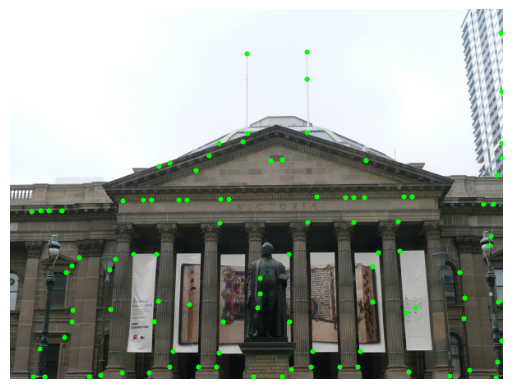

In [58]:
def anms(corners: np.ndarray, num_corners: int) -> np.ndarray:
    """
    Apply Adaptive Non-Maximal Suppression (ANMS) to the detected corners.

    Parameters:
    corners (np.ndarray): Array of detected corners.
    num_corners (int): Number of corners to retain after ANMS.

    Returns:
    np.ndarray: Array of corners retained after ANMS.
    """
    # Initialize radii with infinity
    radii = np.full(corners.shape[0], np.inf)

    # Calculate suppression radius for each corner
    for i, corner in enumerate(corners):
        for j, other_corner in enumerate(corners):
            if i != j:  # Skip the same corner
                # Check if the other corner is stronger than the current corner
                if np.all(corner < other_corner):
                    # Calculate the Euclidean distance between corners
                    dist = np.linalg.norm(corner - other_corner)
                    # Update the suppression radius with the minimum distance
                    radii[i] = min(radii[i], dist)

    # Select the top num_corners corners based on the suppression radius
    top_indices = np.argsort(radii)[-num_corners:]
    top_corners = corners[top_indices]

    return top_corners


# Apply ANMS to the detected corners
num_corners = 100  # Number of corners to retain after ANMS

# Apply ANMS to the Shi-Tomasi corners
anms_corners = anms(shi_tomasi_corners.reshape(-1, 2), num_corners)

# Read the image from the specified path
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Draw ANMS corners on the image
for corner in anms_corners:
    x, y = corner.ravel()
    cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

# Display the image with ANMS corners using matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

## Feature Descriptor

In [57]:
def get_feature_descriptor(
    img: np.ndarray, points: np.ndarray, size: int = 40
) -> np.ndarray:
    """
    Extracts and processes feature descriptors from the given image at the specified points.

    Parameters:
    img (np.ndarray): The input image.
    points (np.ndarray): The points at which the feature descriptors are to be extracted.
    size (int): The size of the patch to be extracted. Default is 40.

    Returns:
    np.ndarray: The processed feature descriptors.
    """

    def get_patch(img: np.ndarray, point: tuple[int, int], size: int) -> np.ndarray:
        """
        Extracts a square patch from the given image centered at the specified point.

        Parameters:
        img (np.ndarray): The input image from which the patch is to be extracted.
        point (tuple[int, int]): A tuple (x, y) representing the center of the patch in the image.
        size (int): The size of the patch to be extracted. The patch will be of dimensions size x size.

        Returns:
        np.ndarray: The extracted image patch of dimensions size x size.

        Notes:
        - The input image is padded with zeros to handle boundary conditions.
        - If the specified point is near the edge of the image, the patch will include the padded zeros.
        - OpenCV's coordinate system is flipped, so ensure the point coordinates are provided accordingly.
        """
        # Pad the image with zeros to handle boundary conditions
        img = np.pad(
            img,
            ((size//2, size//2), (size//2, size//2)),
            mode="constant",
            constant_values=0,
        )
        # Calculate the starting coordinates of the patch
        x_start, y_start = point[1], point[0] # Flip the coordinates for OpenCV
        # Extract the patch from the padded image
        img_patch = img[x_start : x_start + size, y_start : y_start + size]

        return img_patch

    def process_feature(image_patch: np.ndarray, subsample_size: int = 5) -> np.ndarray:
        """
        Processes the image patch to create a feature descriptor.

        Parameters:
        image_patch (np.ndarray): The input image patch.
        subsample_size (int): The size of the step to be used for subsampling. Default is 5.

        Returns:
        np.ndarray: The processed feature descriptor.
        """
        # Apply Gaussian Blur to the image patch
        blurred_patch = cv2.GaussianBlur(image_patch, (5, 5), cv2.BORDER_DEFAULT) 
        # Subsample the blurred image patch to create the descriptor
        descriptor = blurred_patch[::subsample_size, ::subsample_size]
        # Normalize the descriptor to have zero mean and unit variance
        descriptor = (descriptor - np.mean(descriptor)) / np.std(descriptor)
        # Reshape the descriptor to a column vector
        descriptor = descriptor.reshape((-1, 1))
        return descriptor

    def standardize_vector(vector: np.ndarray) -> np.ndarray:
        """
        Standardizes the given vector.

        Parameters:
        vector (np.ndarray): The input vector to be standardized.

        Returns:
        np.ndarray: The standardized vector.
        """
        # Calculate the mean of the vector
        mean = np.mean(vector)
        # Calculate the standard deviation of the vector
        std_dev = np.std(vector)
        # Standardize the vector
        if std_dev == 0:
            standardized_vector = vector - mean
        else:
            standardized_vector = (vector - mean) / std_dev
        return standardized_vector

    descriptors = []
    for point in points:
        # Extract the patch from the image
        patch = get_patch(img, point, size)
        # Process the patch to create the feature descriptor
        vector = process_feature(patch)
        # Standardize the feature descriptor
        standardized_vector = standardize_vector(vector)
        descriptors.append(standardized_vector)

    return np.array(descriptors)


# Example usage
# Read the image from the specified path
img = cv2.imread(image_path)
# Check if the image was successfully read
if img is None:
    raise FileNotFoundError(f"Image not found at the specified path: {image_path}")
# Convert the image to grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Extract and process the feature descriptor with the specified ANMS corners
descriptor = get_feature_descriptor(img, anms_corners)
print(f"Feature Descriptor Shape: {descriptor.shape}")


Feature Descriptor Shape: (100, 64, 1)


## Feature Matching

In [69]:
class FeatureMatcher:
    """
    FeatureMatcher class for matching feature descriptors between multiple images.

    Attributes:
        features_list (list of np.ndarray): List of feature descriptors for each image.
        coords_list (list of np.ndarray): List of coordinates of features for each image.
        threshold (float): Threshold for feature matching.
        pairs (list of tuples): List to store pairs of matching feature indices.
        closest_dist1 (list of np.ndarray): List to store the closest distances for each image.
        closest_dist2 (list of np.ndarray): List to store the second closest distances for each image.

    Methods:
        __init__(features_list: list, coords_list: list, threshold: float):
            Initializes the FeatureMatcher class with feature descriptors and coordinates.
        check_feature(f1_i: int, f2_i: int) -> None:
            Checks the feature descriptor from one image against all descriptors from another image.
        check_against(f1_i: int, f1_feature_i: int, f2_i: int) -> None:
            Compares a feature descriptor from one image with one from another image.
        compute_similarity() -> None:
            Computes the similarity between feature descriptors from multiple images.
        get_feature_pairs() -> list:
            Gets the pairs of matching feature coordinates based on the threshold.
    """

    def __init__(self, features_list: list, coords_list: list, threshold: float):
        """
        Initialize the FeatureMatcher class with feature descriptors and coordinates.

        Parameters:
        features_list (list of np.ndarray): List of feature descriptors for each image.
        coords_list (list of np.ndarray): List of coordinates of features for each image.
        threshold (float): Threshold for feature matching.
        """
        self.features_list = features_list
        self.coords_list = coords_list
        self.threshold = threshold

        self.num_images = len(features_list)  # Number of images
        self.pairs = []  # Initialize list to store pairs of matching features
        self.closest_dist1 = [
            np.full(len(features), np.inf) for features in features_list
        ]  # Initialize closest distances with infinity
        self.closest_dist2 = [
            np.full(len(features), np.inf) for features in features_list
        ]  # Initialize second closest distances with infinity

    def check_feature(self, f1_i: int, f2_i: int) -> None:
        """
        Check the feature descriptor from one image against all descriptors from another image.

        Parameters:
        f1_i (int): Index of the feature descriptor in the first image.
        f2_i (int): Index of the feature descriptor in the second image.
        """
        for i in range(len(self.features_list[f1_i])):  # Iterate over all features in the first image
            if self.features_list[f2_i][i] is not None:  # Check if the feature in the second image is not None
                self.check_against(f1_i, i, f2_i)  # Compare the feature with all features in the second image

    def check_against(self, f1_i: int, f1_feature_i: int, f2_i: int) -> None:
        """
        Compare a feature descriptor from one image with one from another image.

        Parameters:
        f1_i (int): Index of the first image.
        f1_feature_i (int): Index of the feature descriptor in the first image.
        f2_i (int): Index of the second image.
        """
        if self.features_list[f1_i][f1_feature_i] is None:  # If the feature in the first image is None, return
            return
        for j in range(len(self.features_list[f2_i])):  # Iterate over all features in the second image
            dist = np.linalg.norm(
                self.features_list[f1_i][f1_feature_i] - self.features_list[f2_i][j]
            )  # Compute the distance between the two features

            if dist < self.closest_dist1[f1_i][f1_feature_i]:  # If the distance is less than the closest distance
                self.closest_dist2[f1_i][f1_feature_i] = self.closest_dist1[f1_i][
                    f1_feature_i
                ]  # Update the second closest distance
                self.closest_dist1[f1_i][f1_feature_i] = dist  # Update the closest distance
                self.pairs.append((f1_i, f1_feature_i, f2_i, j))  # Add the pair to the list
            elif dist < self.closest_dist2[f1_i][f1_feature_i]:  # If the distance is less than the second closest distance
                self.closest_dist2[f1_i][f1_feature_i] = dist  # Update the second closest distance

    def compute_similarity(self) -> None:
        """
        Compute the similarity between feature descriptors from multiple images.
        """
        for i in range(self.num_images):  # Iterate over all images
            for j in range(i + 1, self.num_images):  # Iterate over all pairs of images
                self.check_feature(i, j)  # Check the features between the two images

    def get_feature_pairs(self) -> list:
        """
        Get the pairs of matching feature coordinates based on the threshold.

        Returns:
        list: List of matching feature coordinates from all images.
        """
        matching_pairs = []  # Initialize list to store matching pairs
        for pair in self.pairs:  # Iterate over all pairs
            f1_i, f1_feature_i, f2_i, f2_feature_i = pair  # Unpack the pair
            ratio = (
                self.closest_dist2[f1_i][f1_feature_i]
                - self.closest_dist1[f1_i][f1_feature_i]
            ) / self.closest_dist2[f1_i][f1_feature_i]  # Compute the ratio of distances

            if ratio >= self.threshold:  # If the ratio is greater than or equal to the threshold
                matching_pairs.append(
                    (
                        self.coords_list[f1_i][f1_feature_i],
                        self.coords_list[f2_i][f2_feature_i],
                    )
                )  # Add the matching pair to the list

        return matching_pairs  # Return the list of matching pairs

### Test class for three images

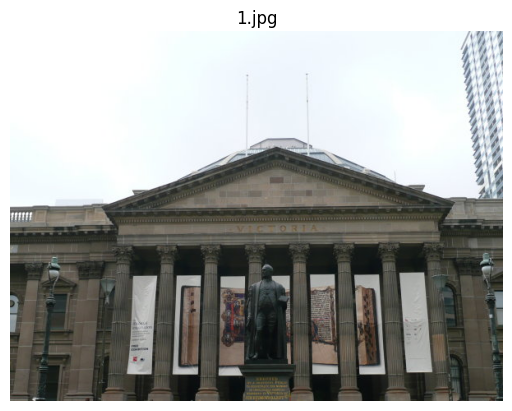

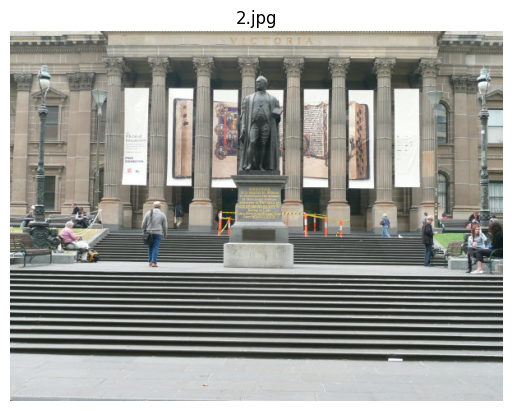

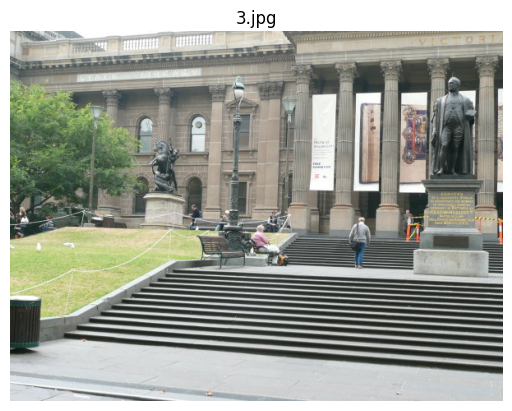

In [66]:
# Extract the directory from the image path
image_directory = os.path.dirname(image_path)

# List all files in the directory
all_files = os.listdir(image_directory)

# Filter out the image files (assuming they are .jpg files)
image_files = [f for f in all_files if f.endswith('.jpg')]

# Display each image in the directory
for image_file in image_files:
    img_path = os.path.join(image_directory, image_file)
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(image_file)
    plt.axis("off")
    plt.show()

Matching Pairs: []


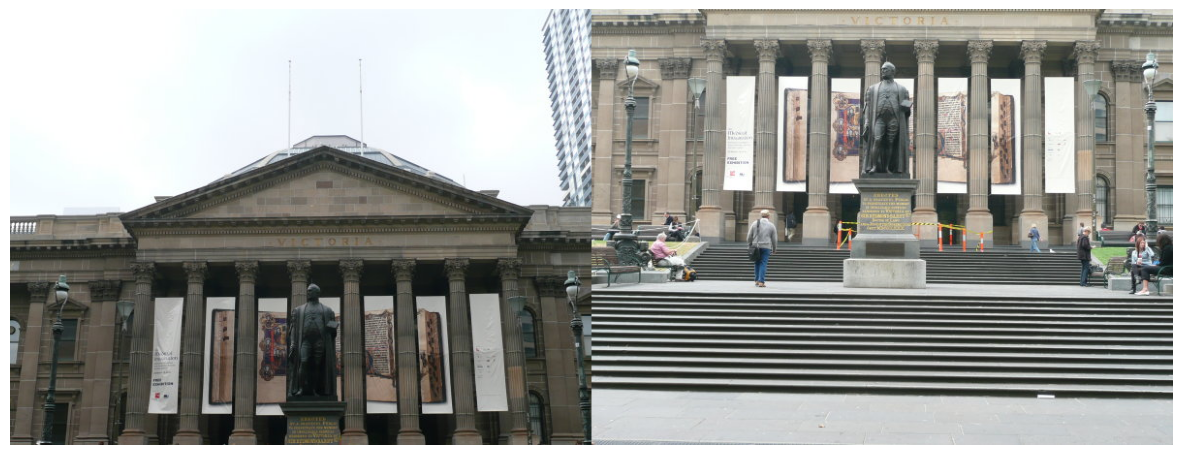

In [72]:
# Initialize lists to store feature descriptors and coordinates for each image
features_list = []
coords_list = []

# Use only the first two images
image_files = image_files[:2]

# Loop through each image file
for image_file in image_files:
    img_path = os.path.join(image_directory, image_file)
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {img_path}")
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply the Shi-Tomasi corner detection
    shi_tomasi_corners = cv2.goodFeaturesToTrack(
        gray, maxCorners=500, qualityLevel=0.01, minDistance=10
    )
    # Convert the corner coordinates to integer values
    shi_tomasi_corners = np.intp(shi_tomasi_corners)
    
    # Apply ANMS to the detected corners
    anms_corners = anms(shi_tomasi_corners.reshape(-1, 2), num_corners)
    
    # Extract and process the feature descriptor with the specified ANMS corners
    descriptor = get_feature_descriptor(gray, anms_corners)
    
    # Append the descriptors and coordinates to the lists
    features_list.append(descriptor)
    coords_list.append(anms_corners)

# Initialize the FeatureMatcher with the extracted features and coordinates
threshold = 0.8  # Set a threshold for feature matching
matcher = FeatureMatcher(features_list, coords_list, threshold)

# Compute the similarity between feature descriptors from multiple images
matcher.compute_similarity()

# Get the pairs of matching feature coordinates
matching_pairs = matcher.get_feature_pairs()

# Print the matching pairs
print(f"Matching Pairs: {matching_pairs}")

# Read the images again for displaying matches
images = [cv2.imread(os.path.join(image_directory, image_file)) for image_file in image_files]

# Convert images to grayscale
gray_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

# Create a list of keypoints for each image
keypoints_list = [cv2.KeyPoint(x=float(c[0]), y=float(c[1]), size=1) for coords in coords_list for c in coords]

# Create a list of DMatch objects for the matching pairs
matches = [cv2.DMatch(_queryIdx=i, _trainIdx=j, imgIdx=0, distance=0) for i, (c1, c2) in enumerate(matching_pairs) for j, c in enumerate(coords_list[1]) if np.array_equal(c, c2)]

# Draw the matches
img_matches = cv2.drawMatchesKnn(images[0], keypoints_list[:len(coords_list[0])], images[1], keypoints_list[len(coords_list[0]):], [matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the image with matches
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()